# Score vs N

In this notebook we plot the score, # of tests, # of FPs and # of FNs for several values of N. 

In [1]:
import os
os.chdir("../")

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
from src import utils
import matplotlib.pyplot as plt

sns.set_theme(context='paper', style='ticks', font_scale=1)

In [3]:
name="score_vs_N"
golden = (1 + 5 ** 0.5) / 2
font_scale = 3.5
fig_height = 7
type_dict = {
    'N' : int, 
    'false_negatives' : int,
    'false_positives' : int,
    'k' : float,
    'lambda_1' : float,
    'lambda_2' : float,
    'method' : str,
    'num_of_infected' : int,
    'num_of_tests' : int,
    'group_size' : float,
    'r' : float,
    'score' : float,
    'se' : float,
    'sp' : float,
    'seed' : int
}

In [4]:
files = glob.glob("./outputs/{name}_*.json".format(name=name))

data = []
for fl_id, fl in enumerate(files):
    with open(fl,"r") as f:
        df = pd.DataFrame.from_records(json.load(f), index=[fl_id])
        data.append(df)

input_df = pd.concat(data)

In [17]:
total_df = input_df.astype(type_dict) # Fix types
total_df = total_df.rename(columns={"method": "Method", "score": "Score"}) # Rename columns
total_df = total_df.replace({'dorfman': 'Dorfman', 'individual': 'Individual', 'negbin': 'Algorithm 1'}) # Rename methods
# temp_1 = total_df[(total_df['lambda_1']==0.0) & (total_df['lambda_2']==0.0) & (total_df['N']==100) & (total_df['Method']=='Dorfman')]['num_of_tests'].tolist()
# temp_2 = total_df[(total_df['lambda_1']==0.0) & (total_df['lambda_2']==0.0) & (total_df['N']==100) & (total_df['Method']=='Algorithm 1')]['num_of_tests'].tolist()
temp = total_df[(total_df['lambda_1']==0.0) & (total_df['lambda_2']==0.0) & (total_df['N']==20)]
# temp[temp['seed']==2]
temp[temp['Method']=='Algorithm 1']['Score'].median()

9.0

In [6]:
# from scipy.stats import mannwhitneyu
# mannwhitneyu(temp_1, temp_2)

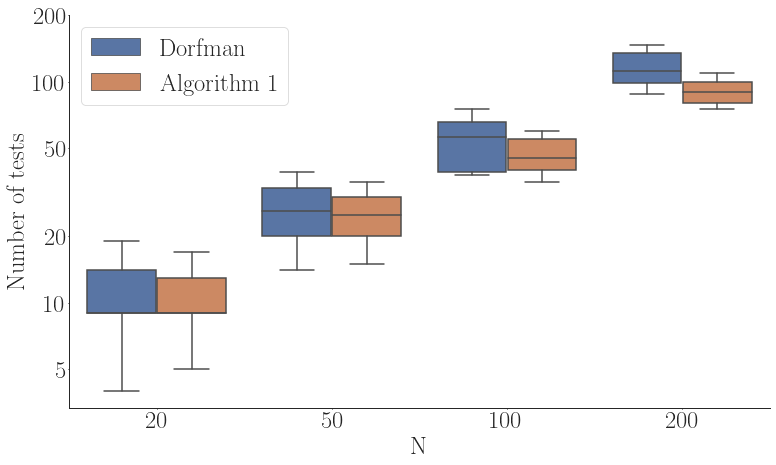

In [7]:
utils.latexify(fig_width=fig_height*golden, fig_height=fig_height, font_scale=font_scale)
tests_df = total_df[(total_df['lambda_1']==0.0) & (total_df['lambda_2']==0.0) & (total_df['N']>=20) & (total_df['Method']!='Individual')]

g = sns.catplot(data=tests_df, x="N", y="Score", kind='box', aspect=golden, height=fig_height, whis=[15, 85], showfliers=False,
                legend=False, hue="Method", palette="deep", hue_order=['Dorfman', 'Algorithm 1']) #showfliers=False

# g = sns.catplot(data=tests_df, x="N", y="Score", kind='violin', aspect=golden, height=fig_height,
#                 legend=False, hue="Method", palette="deep", hue_order=['Dorfman', 'Algorithm 1']) #showfliers=False

g.set_ylabels('Number of tests')
g.ax.legend(loc='upper left')
g.ax.set_yscale('log')
g.ax.set_yticks([5, 10, 20, 50, 100, 200])
g.ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

g.tight_layout()
g.savefig('figures/{name}_tests.pdf'.format(name=name))

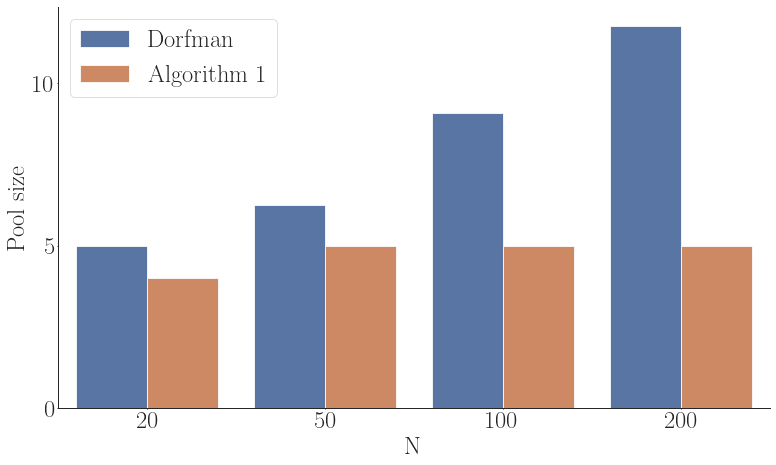

In [8]:
utils.latexify(fig_width=fig_height*golden, fig_height=fig_height, font_scale=font_scale)
tests_df = total_df[(total_df['lambda_1']==0.0) & (total_df['lambda_2']==0.0) & (total_df['N']>=20) & (total_df['Method']!='Individual')]

g = sns.catplot(data=tests_df, x="N", y="group_size", kind="bar", height=fig_height, aspect=golden,
                hue="Method", legend=False, ci=None, palette="deep", hue_order=['Dorfman', 'Algorithm 1'])

g.set_ylabels('Pool size')
g.ax.legend(loc='upper left')
g.ax.set_yticks([0, 5, 10])

g.tight_layout()
g.savefig('figures/{name}_pool_size.pdf'.format(name=name))

In [ ]:
# THE FOLLOWING ARE EXCLUDED FOR NOW

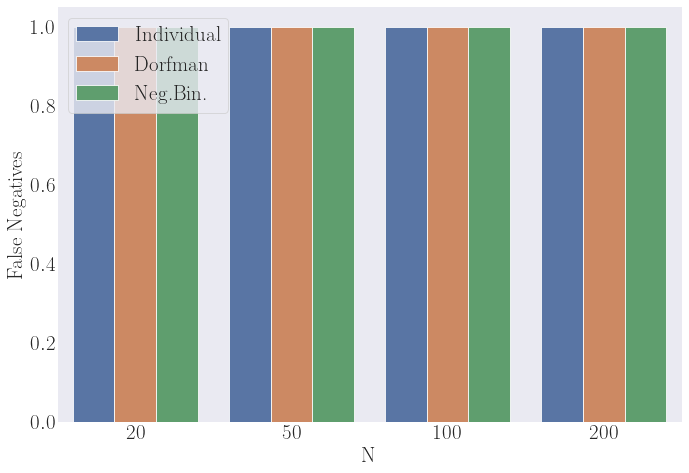

In [76]:
utils.latexify(fig_width=10, fig_height=7, font_scale=3)
FN_df = total_df[(total_df['lambda_1']==1.0) & (total_df['lambda_2']==0.0) & (total_df['N']>=20)]

g = sns.catplot(
    data=FN_df, kind="bar",
    x="N", y="group_size", hue="Method", legend=False,
    ci=95, palette="deep", height=7, aspect=10/7, hue_order=['Individual', 'Dorfman', 'Neg.Bin.'])

g.set_ylabels('False Negatives')
g.fig.get_axes()[0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('figures/{name}_FNs.pdf'.format(name=name))

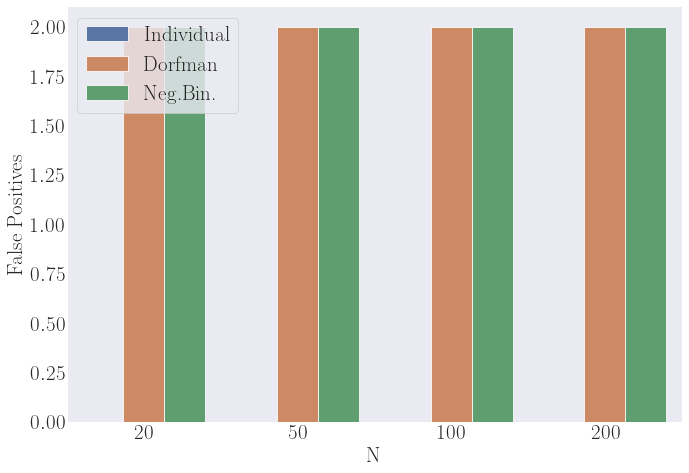

In [77]:
utils.latexify(fig_width=10, fig_height=7, font_scale=3)
FP_df = total_df[(total_df['lambda_1']==0.0) & (total_df['lambda_2']==1.0) & (total_df['N']>=20)]

g = sns.catplot(
    data=FP_df, kind="bar",
    x="N", y="group_size", hue="Method", legend=False,
    ci=95, palette="deep", height=7, aspect=10/7, hue_order=['Individual', 'Dorfman', 'Neg.Bin.'])

g.set_ylabels('False Positives')
g.fig.get_axes()[0].legend(loc='upper left')

plt.tight_layout()
plt.savefig('figures/{name}_FPs.pdf'.format(name=name))